# Data analysis script

## Input
a single file received from running `grim dump` on the payload

## Output
- FILL THIS IN

In [147]:
import struct
import base64
from collections import namedtuple
from typing import Tuple, List
import pandas as pd
import os


## Data opening and parsing
- open a file to bytes
- bytes to lists of data

In [148]:
SEPARATOR = "********\n"
filename = 'data/all.cap'
ouptut_dir = 'out2'

In [149]:
def file_to_bytes(filename: str) -> Tuple[bytes, bytes, bytes, bytes, bytes]:
    with open(filename, 'r') as f:
        parts = f.read().split(SEPARATOR)
        if len(parts) != 5:
            print("wrong number of parts. did you remove all extra lines on top and bottom")
        byte_parts = [base64.b64decode(part) for part in parts]
        return tuple(byte_parts)

In [150]:
SlowData = namedtuple('SlowData', ['timestamp', 'humidity', 'temperature', 'grim_voltage', 'grim_current', 'load_cell_voltage', 'load_cell_current', 'bat_voltage', 'bat_current'])
FastData = namedtuple('FastData', ['timestamp', 'accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz', 'pressure'])
ADCData = namedtuple('ADCData', ['timestamp', 'reading'])
# PreIMUData is FastData
PreALTData = namedtuple('PreALTData', ['timestamp', 'pressure', 'temperature'])


In [151]:
slow_units = SlowData('ms', '% humidity', 'degrees C', 'mV', 'mA', 'mV', 'mA', 'mV', 'mA')
fast_units = FastData('ms', 'm/s^2', 'm/s^2', 'm/s^2', 'rad/s',  'rad/s',  'rad/s', 'kPa')
adc_units = ADCData('ms', 'LSB')
pre_altitude_units = PreALTData('ms', 'kPa', 'degrees C')

In [152]:
slow_fmt='IffHHHHHH' # timestamp, humid, temp, (voltage, current) * 3
fast_fmt = 'Ifffffff' # timestamp accxyz, gyro xyz, press
adc_fmt = 'Iiiiiiiiiii' # timestamp + 10 int32s
imu_boost_detect_fmt = fast_fmt
alt_boost_detect_fmt = 'Iff' # timestamp, press, temp

In [153]:
slow_bs, fast_bs, adc_bs, pre_imu_bs, pre_alt_bs = file_to_bytes(filename)

In [154]:
def interpolate_adc(entries: List[List]) -> List[ADCData]:
    l = []
    for i, entry in enumerate(entries[:-1]):
        start_time = entries[i][0]
        period = entries[i+1][0] - entries[i][0]
        per = period / 10.0
        for j, sample in enumerate(entry[1:]): 
            l.append(ADCData(start_time + j * per, sample))
    return l

In [196]:
pimu_bs = '''
wzcAAEjhUMGR7efB6SZdQphuSsCS7fw/j8IVPwAAAADFNwAAPQpPwWIQ5MEE1lpCQDVGwIXrsT9iENg+AAAAAMg3AABqvE7B
dZPgwSuHVkLsUTjAEoPAPmDlUL4AAAAAyjcAABsvQcGoxt7BXrpIQkjhMsAxCCy9XroJvwAAAADMNwAA0SI5wTeJ4MGFa0BC
ppskwOkmsb4OLTK/AAAAAM43AACR7UTBNV7jwVyPNkIhsBrAxSCAv1pki78AAAAA0jcAAEjhQMFg5eXBTmImQr6fAsBmZh7A
pHDNvwAAAADUNwAAxSA8wQrX6sG+HxBCQDXuv3e+P8CJQfC/AAAAANY3AACJQUDBMQjrweVQB0Iv3eS/7nxnwFYODcAAAAAA
2DcAABfZNsEMAufBzczpQdej4L+q8XrAokUWwAAAAADcNwAAqvFSwVyP3MFSuNFBqMbbv7gejcAhsDLAAAAAAN43AAAQWF/B
okXGwXWTnkEv3dS/yXaewBsvRcAAAAAA4DcAAAwCRcF3vqrBgZV/QYPAyr+0yJ7ADAJTwAAAAADiNwAAqMY1wc/3i8F9P2NB
8KfGvzm0lMBCYGXAAAAAAOY3AAAv3TDBRItWwe58L0GJQdC/9P2QwBbZdsAAAAAA6DcAAPCnLMEv3UzAFtl2QHA92r+4HpnA
xSCAwAAAAADqNwAA5dAcwdEi6z9CYGW8bOfbv3NoocCynYfAAAAAAOw3AADufO/Ai2wLQaJFrsB9P9W/2/mmwHWTiMAAAAAA
7jcAAK5HOcAzM11BlkMfwTzfz7+e76fAuB6JwAAAAADxNwAARIu8P8UgxEG+n5PBOInBv2iRpcCHFoHAAAAAAPM3AAArh5JA
46XpQfyprMFg5cC/ObSYwNV4acAAAAAA9TcAAKJFHEFz6ANCH4W7wcuhtb/2KLTA0SJrwAAAAAD3NwAAVg5bQV46FkKmm+LB
QmCFv2ZmTsD6fjLAAAAAAPs3AAArh6hB4XovQmIQBMLVeOm+nMQQwAAAwL8AAAAA/TcAADvfuUFECzpCe5QQwqRwPb4GgbW/
BFauvwAAAAD/NwAAuknLQTVeQ0LNzBfC308NvmIQmL9QjZe+AAAAAAE4AAC8dNBB081EQgpXH8KWQ4u8QmDlvClcj70AAAAA
BTgAACcxv0FvkjxC7FEXwukmMT7sUVg/N4mxPwAAAAAHOAAAoBq5QaAaMUIjWxPCtvP9PbpJzD9qvBRAAAAAAAk4AAB/aqdB
YhAlQh+FCcIMAis+WDk8QHWTIEAAAAAACzgAAEoMi0Gk8BVCDAIDwiGwcj7jpXtAeelWQAAAAAAPOAAAVg45QeOl8UEhsOHB
Vg4tPv7UrECJQYRAAAAAABE4AACkcNlAlkPJQX0/vMFQjZc9dZPIQP7UhEAAAAAAEzgAAFCN1z6LbJRBfT+awUJg5bwSg9RA
6iaRQAAAAAAVOAAADAKTwOf7SUEhsFjBj8J1vlYO4UDRIotAAAAAABg4AABEiyTBFK6DQCUGD8GR7Ry/MzPnQIlBkEAAAAAA
GjgAADMzi8FU49nAmpk5QHsUTr9cj+ZAO9+LQAAAAAAcOAAASgykwXWTLMExCFJBRraTvyGw8kBU44FAAAAAAB84AABmZqrB
qMZ3wRsvuUE6tNi/y6G1QMdLb0AAAAAAIjgAAK5HxcHP95vBosUIQk5i4L8nMbxAKVw/QAAAAAAkOAAAJzG2wSUG7MGNF0VC
y6Hlv90kikDLoS1AAAAAACY4AAAX2ZzB7nz8wfaoZ0LZzve/16NoQEJgHUAAAAAAKDgAABsvjsGiRQTCPQqFQn0/1b9MN2FA
qMbbPwAAAAAsOAAA46WFwRSuA8L8aYtCmpmJvy/dFED2KFw/AAAAAC44AACLbHHBL931wfR9jUIpXE+/UI23Pz0Kdz8AAAAA
MDgAAHE9ZsGkcOXBhSuIQoPAir72KFw/4XoUPwAAAAAyOAAAsHJawe5828GixYJCGy9dPWIQWD6q8dI+AAAAADY4AADVeFPB
RIvWwT2KeULdJCY/16NwvycxiL4AAAAAODgAAB+FScEhsODB5/tfQqJFdj+JQcC/xSCwvgAAAAA6OAAAqMZVwbge58EzM1dC
FK6XP6rxAsCDwCq/AAAAADw4AAD0/VjBYOXuweVQRkKYbqI/GQQWwDEIjL8AAAAAPzgAAJqZa8F9P/XBpps4QkoMoj/JdlbA
3STmvwAAAABCOAAA8KeEwT0K+sE/NRtCnu+XP1TjdcByaPG/AAAAAEQ4AAAbL4fBoBr0wbx0DkJcj4I/0SKHwFCNF8AAAAAA
RjgAAE5ihcGF6+nBQDX/QZ7vRz/wp5LAnMQYwAAAAABIOAAAKVyCwY2X1MFOYuhB9igcP/CnlsA1XjrAAAAAAEs4AABWDpHB
tvOowQaBvUFkO18+EFidwCPbacAAAAAATTgAALKdjcHAyo/Bbee6QZqZGT5KDKbARrZrwAAAAABPOAAADAIlwc/3O8Feut1A
tvN9vqrxmsDFIITAAAAAAFE4AABcj4DBgZULwfypCUEGgRW+RIvMwClcg8AAAAAAVTgAAJQY9MCe7wc/pHAVwBSuR77Xo8zA
QmCNwAAAAABXOAAApps8wEA12kCkcJXAhetRvgisqMC6SZDAAAAAAFk4AACNl56/okVOQS/dQsHLoYW+dZOIwCcxjMAAAAAA
WzgAAA4tOkBvEp5BlkOXwYtsZ77ByoHAd76LwAAAAABfOAAA5/sHQRBY2EHRIv3BObSIPsuhfcDLoX3AAAAAAGE4AAD2KCRB
j8L7QSUGCML0/TS/5dCmwH9qgMAAAAAAYzgAAHe+bUFg5QpCrBwOwnsUjj8j23nADAJbwAAAAABlOAAAtMiZQbx0F0I7XxzC
jZdOP9v5JsApXBfAAAAAAGk4AACamblBZmYnQrbzKMJSuB4/QmAFv6Rwfb8AAAAAazgAALpJw0HVeCxC3aQwwphu8j9g5TA/
tMiGvwAAAABtOAAAYOXEQfYoLUIhsDPCWmTrP9NNYj5CYGU8AAAAAG84AAAdWrZBj0IoQqhGKcI+Crc/RrZTP7TIdj4AAAAA
cjgAAAIrrEFvEh9C0aIqwuxRiD83iQFA8KfGPwAAAAB1OAAAfT+aQY0XDkICKxvC9iisPwwCe0CgGhdAAAAAAHc4AAAGgYxB
PQoFQgTWC8KLbGc/lBicQHe+F0AAAAAAeTgAAFCNY0EAAPJBsHL8wRsvPT8dWpxAHVo8QAAAAAB8OAAABoErQX0/1EFSuLnB
hevRPhkE1kApXGdAAAAAAH44AAAbL0VAVg6KQTMzTcGamRk+d77bQEA1bkAAAAAAgDgAAEoMGsDNzC5B4XoAwbx0kzw73+dA
WmSDQAAAAACCOAAA5/vJwOOly0CMbOe/MQisvEA16kBokX1AAAAAAIY4AABeui3BO9+fP1pkg0AIrJy+oBrfQCuHgkAAAAAA
iDgAAHWThMFeup3AObSbQW3n+77Ays1ASgx6QAAAAACKOAAAaJGXwbx0+8C4HgRCrkdBv39qvEDEIGBAAAAAAIw4AAACK6LB
/KlNwaTwJkIOLRK/f2qIQK5HUUAAAAAAkDgAACGwp8EdWozBuslLQrbzXb/VeFFAGi8lQAAAAACSOAAAK4eXwQis08Gw8oFC
YOVwv2IQYEAEVhZAAAAAAJQ4AACPwobBarznwVwPiUJokS2/DAI7QPT99D8AAAAAljgAAEw3e8H6furBhSuKQsuhBb+S7dw/
rBzaPwAAAACaOAAAke14warx48HP94dCz/fTvqJFdj8xCGw/AAAAAJA3AAAQWC1BUjgUQpZDr8FQjRc9ObQgwEoMEsAAAAAA
kjcAAL6fZkGsnBpC8tK7weF6FD59Py3AvHTjvwAAAACUNwAA9iiLQdcjIUJ7FL/BCtejPhKDQL9g5bC/AAAAAJc3AADsUbNB
O98kQsuhy8FkOz8/CtejvTEILL4AAAAAmTcAAAaBtkGuRyRCsHLKwWDlUD/dJEY/Di2yPgAAAACbNwAAYOW0Qa5HIELHS8rB
+FNDP1CNpz9Eiww/AAAAAJ43AADD9aZBRIsYQsUgzcHfT20/gZUDQM3MnD8AAAAAoTcAACPbgkFMtwhCXrq3wfT9ND/EIChA
FK4XQAAAAACjNwAALbJnQYGV+EElBqnBgZUDPxsvVUDdJDZAAAAAAKU3AAAnMT5BPQrgQVpkk8GgGg8/g8CGQEoMQkAAAAAA
pzcAAARWDkEtsr1BqMZlwd0kxj7HS5dAFK5HQAAAAACrNwAAbxKDOzVefEHfT9HAvHSTvAwCr0D6flpAAAAAAK03AACoxmvA
cT00QVK43j74U+O9NV62QC2yXUAAAAAArzcAAARW4sBKDJZANV7aQIlB4L7y0rVAMQhMQAAAAACxNwAAfT8zwVTjJb7LoWVB
309Nv8dLr0BmZkZAAAAAALU3AADRIm3B46UdwaJF+UHEINC/CtePQH9qNEAAAAAAtzcAAH9qjsG6SYjBjRcbQmIQ2L+F65FA
RrYbQAAAAAC5NwAALbKDwfyprMGHljhC5dAawNv5hkAtshVAAAAAALs3AAArh3rBEoPMwfLSSEL4UyPAf2pkQC/d9D8AAAAA
vzcAAIGVbcFMN9zBXI9YQgrXO8D+1DhAi2ynPwAAAADBNwAATDdZwcl26MHdpF5Cz/dDwGIQAEDD9Yg/AAAAALYwAADhejDB
ppsWQfp+LsGiRcbAN4mNQP7UIEEAAAAAuDAAAEjhPsGNl4pAFtn2wCuHpsB1k4BA5/shQQAAAAC8MAAA46WOwQIrEcF/aozA
f2qcwH0/bUCamR1BAAAAAL4wAABYObDBz/eDwQRWFsAdWmzAtvNVQPhTF0EAAAAAwDAAAIGV1sFSuNnBTmJwwHE9SsD4U3tA
9igQQQAAAADCMAAA0036wVpkEMK2823AUI03wHNocUDwpwJBAAAAAMUwAACDQAnCQuBawjMzK8BkO9+/arxUQPT90EAAAAAA
xzAAAPAnCcI59ILC9P10v6Rwfb81XjJA1XipQAAAAADJMAAAmG4Dwl46kMJOYrA/hxYZv6RwHUA9CotAAAAAAMswAACe7/XB
Vo6ewkw3yUBoka0+Di0SQOomWUAAAAAA
'''

In [197]:
slow_lists = list(struct.iter_unpack(slow_fmt, slow_bs))
fast_lists = list(struct.iter_unpack(fast_fmt, fast_bs))
adc_lists = list(struct.iter_unpack(adc_fmt, adc_bs))
pre_imu_lists = list(struct.iter_unpack(imu_boost_detect_fmt, pre_imu_bs))
pre_alt_lists = list(struct.iter_unpack(alt_boost_detect_fmt, pre_alt_bs))


In [198]:
def unit_slow_data(l: List) -> SlowData:
    dr = SlowData(*l)
    du = SlowData(dr.timestamp, dr.humidity, dr.temperature, 1.25 * dr.grim_voltage, 1.25 * dr.grim_voltage, 1.25 * dr.load_cell_voltage, 1.25 * dr.load_cell_current, 1.25 * dr.bat_voltage, 1.25 * dr.bat_current)
    return du

In [204]:
slow_data = [unit_slow_data(l) for l in slow_lists]
fast_data = [FastData(*l) for l in fast_lists]
adc_data = interpolate_adc(adc_lists)

pre_imu_data_circ = [FastData(*l) for l in pre_imu_lists if l[0] != 0][:-14]
# filter out timestamp = 0 (unwritten) entries
# order by timestamp bc the circular buffer may not begin with the earliest entry
pre_imu_data = sorted(pre_imu_data_circ, key = lambda d : d.timestamp)
pre_alt_data = sorted([PreALTData(*l) for l in pre_alt_lists if l[0] != 0], key = lambda d : d.timestamp)

In [207]:
slow_data_elapsed_s = (slow_data[-1].timestamp - slow_data[0].timestamp) / 1000.0
fast_data_elapsed_s = (fast_data[-1].timestamp - fast_data[0].timestamp) / 1000.0
adc_data_elapsed_s = (adc_data[-1].timestamp - adc_data[0].timestamp) / 1000.0

flight_elapsed_s = adc_data_elapsed_s

pre_alt_elapsed_ms = pre_alt_data[-1].timestamp - pre_alt_data[0].timestamp
pre_imu_elapsed_ms = pre_imu_data[-1].timestamp - pre_imu_data[0].timestamp

In [208]:
print(f"IMU Buffer Time: {pre_imu_elapsed_ms} ms")
print(f"ALT Buffer Time: {pre_alt_elapsed_ms} ms")
print(f"Flight Time: {flight_elapsed_s} s")

IMU Buffer Time: 266 ms
ALT Buffer Time: 4990 ms
Flight Time: 399.9968 s


In [209]:
percent_imu = 250 / pre_imu_elapsed_ms
print(f"Suggest {percent_imu} of current IMU Buffer size")

Suggest 0.9398496240601504 of current IMU Buffer size


In [210]:
# calculate average period of each reading thread
print(f"{len(slow_data)} slow entries.  avg {flight_elapsed_s / len(slow_data)} second period")
print(f"{len(fast_data)} fast entries.  avg {1000 * flight_elapsed_s / len(fast_data)} ms period")
print(f"{len(adc_data)} adc entries.  avg {1000 * flight_elapsed_s / len(adc_data)} ms period")


400 slow entries.  avg 0.999992 second period
112861 fast entries.  avg 3.544154313713329 ms period
1824150 adc entries.  avg 0.2192784584601047 ms period


In [233]:
slow_df = pd.DataFrame(slow_data)
fast_df = pd.DataFrame(fast_data)
adc_df = pd.DataFrame(adc_data)

pre_imu_df = pd.DataFrame(pre_imu_data)
pre_alt_df = pd.DataFrame(pre_alt_data)



In [234]:
# set T=0 to start of boost accel buffer
start = pre_imu_df['timestamp'][0]

slow_df['timestamp'] = slow_df['timestamp'] - start
fast_df['timestamp'] = fast_df['timestamp'] - start
adc_df['timestamp'] = adc_df['timestamp'] - start

pre_imu_df['timestamp'] = pre_imu_df['timestamp'] - start
pre_alt_df['timestamp'] = pre_alt_df['timestamp'] - start

In [221]:
def add_units_to_df(df: pd.DataFrame, units):
    new_names = {}
    for unit, (series_name, _) in zip(units, df.items()):
        new_names[series_name] = f"{series_name} ({unit})"
    return df.rename(columns=new_names)

In [222]:
if not os.path.exists(ouptut_dir):
    os.makedirs(ouptut_dir)

add_units_to_df(slow_df, slow_units).to_csv(ouptut_dir+'/slow.csv', index=False)
add_units_to_df(fast_df, fast_units).to_csv(ouptut_dir+'/fast.csv', index=False)
add_units_to_df(adc_df, adc_units).to_csv(ouptut_dir+'/adc.csv', index=False)
add_units_to_df(pre_alt_df, pre_altitude_units).to_csv(ouptut_dir+'/pre_imu.csv', index=False)
add_units_to_df(pre_imu_df, fast_units).to_csv(ouptut_dir+'/pre_alt.csv', index=False)

In [235]:
from functools import reduce

all_dfs = [fast_df, slow_df, adc_df, pre_imu_df, pre_alt_df]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp'],
                                            how='outer'), all_dfs)

/tmp/ipykernel_949353/3354534737.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp'],
/tmp/ipykernel_949353/3354534737.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp'],
/tmp/ipykernel_949353/3354534737.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp'],


In [236]:
df_merged.interpolate(inplace=True, limit_direction='both')

In [237]:
df_merged

,timestamp,accx_x,accy_x,accz_x,gyrox_x,gyroy_x,gyroz_x,pressure_x,humidity,temperature_x,...,reading,accx_y,accy_y,accz_y,gyrox_y,gyroy_y,gyroz_y,pressure_y,pressure,temperature_y
0,268.0,-13.710,-27.421000,58.627998,-0.378,-0.289,0.302,97.351326,32.798828,29.690001,...,-3268.0,-15.558,-28.493,67.984001,-0.414,0.962,0.922,0.0,97.348358,29.990000
1,271.0,-12.911,-28.374001,52.421001,-0.340,-1.282,-0.002,97.351326,32.798828,29.690001,...,-3338.0,-15.558,-28.493,67.984001,-0.414,0.962,0.922,0.0,97.348358,29.990000
2,275.0,-12.547,-28.819000,48.306000,-0.239,-1.711,-0.520,97.351326,32.798828,29.690001,...,-3369.0,-15.558,-28.493,67.984001,-0.414,0.962,0.922,0.0,97.348358,29.990000
3,278.0,-13.347,-29.733000,42.553001,-0.101,-2.386,-1.145,97.351326,32.798828,29.690001,...,-3400.0,-15.558,-28.493,67.984001,-0.414,0.962,0.922,0.0,97.348358,29.990000
4,282.0,-13.529,-30.340000,37.007000,-0.012,-3.225,-1.666,97.351326,32.798828,29.690001,...,-3251.0,-15.558,-28.493,67.984001,-0.414,0.962,0.922,0.0,97.348358,29.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846594,225.0,1.928,-0.674000,10.351000,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.0,-15.701,-29.312,69.084999,-0.522,1.726,1.704,0.0,97.351326,30.030001
1846595,235.0,1.928,-0.674000,10.351000,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.0,-15.701,-29.312,69.084999,-0.522,1.726,1.704,0.0,97.351326,30.030001
1846596,244.0,1.928,-0.674000,10.351000,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.0,-15.701,-29.312,69.084999,-0.522,1.726,1.704,0.0,97.351326,30.030001
1846597,254.0,1.928,-0.674000,10.351000,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.0,-15.701,-29.312,69.084999,-0.522,1.726,1.704,0.0,97.351326,30.030001


In [239]:
df_merged.sort_values('timestamp')

,timestamp,accx_x,accy_x,accz_x,gyrox_x,gyroy_x,gyroz_x,pressure_x,humidity,temperature_x,...,reading,accx_y,accy_y,accz_y,gyrox_y,gyroy_y,gyroz_y,pressure_y,pressure,temperature_y
1846099,-4726.0,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.000000,-15.701000,-29.312000,69.084999,-0.522000,1.726000,1.704000,0.0,97.348358,29.99
1846100,-4715.0,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.000000,-15.701000,-29.312000,69.084999,-0.522000,1.726000,1.704000,0.0,97.348358,29.99
1846101,-4705.0,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.000000,-15.701000,-29.312000,69.084999,-0.522000,1.726000,1.704000,0.0,97.348358,29.99
1846102,-4696.0,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.000000,-15.701000,-29.312000,69.084999,-0.522000,1.726000,1.704000,0.0,97.348000,29.99
1846103,-4686.0,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.000000,-15.701000,-29.312000,69.084999,-0.522000,1.726000,1.704000,0.0,97.348000,29.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845991,400262.4,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2602.000000,10.833954,37.054887,-21.907845,0.036999,-2.510994,-2.281995,0.0,97.348358,29.99
1845992,400262.6,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2728.000000,10.833969,37.054925,-21.907897,0.036999,-2.510996,-2.281996,0.0,97.348358,29.99
1845993,400262.8,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,23.298828,35.790001,...,-2587.000000,10.833984,37.054962,-21.907949,0.037000,-2.510998,-2.281998,0.0,97.348358,29.99
112860,400265.0,1.928,-0.674,10.351,0.031,-0.054,-0.031,97.351135,33.005951,29.847020,...,-2845.666667,-15.558000,-28.493000,67.984001,-0.414000,0.962000,0.922000,0.0,97.348358,29.99


<Axes: xlabel='timestamp'>

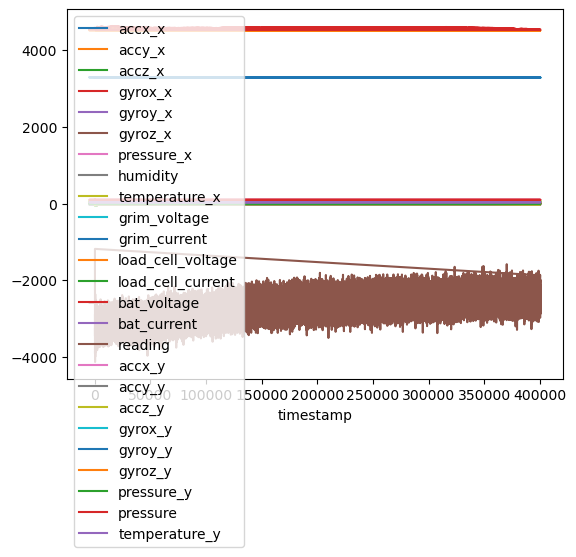

In [240]:
df_merged.plot('timestamp')

<Axes: xlabel='timestamp'>

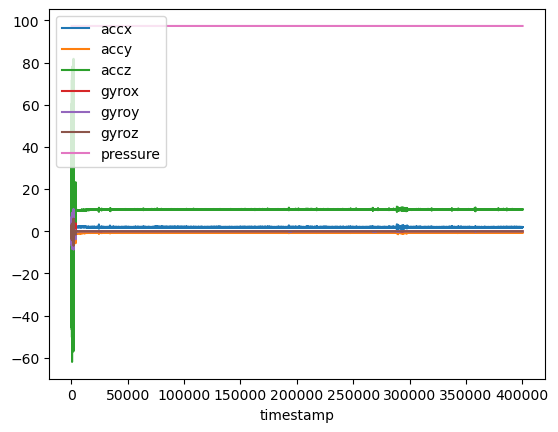

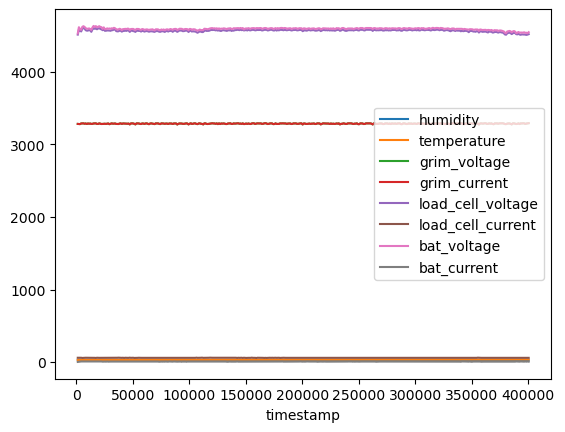

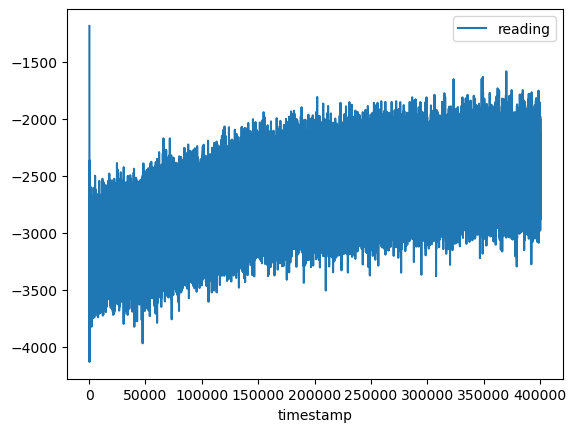

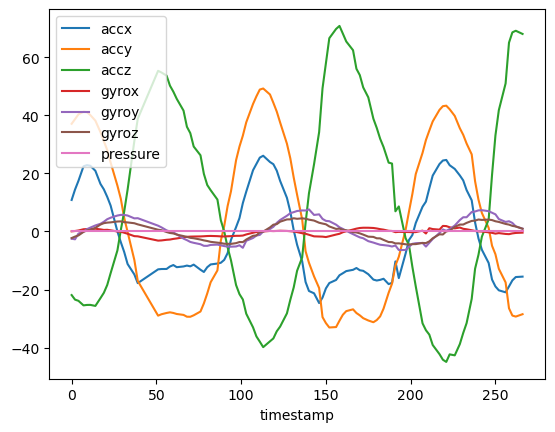

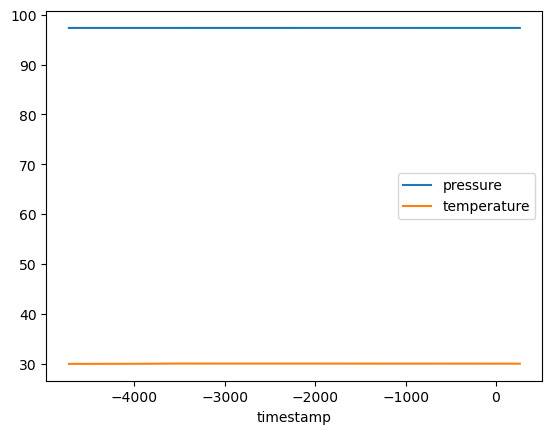

In [219]:
fast_df.plot('timestamp')
slow_df.plot('timestamp')
adc_df.plot('timestamp')

pre_imu_df.plot('timestamp')
pre_alt_df.plot('timestamp')